# Parkinson's Disease Detection using Voice Features with Machine Learning Models and Ensemble Voting Classifier
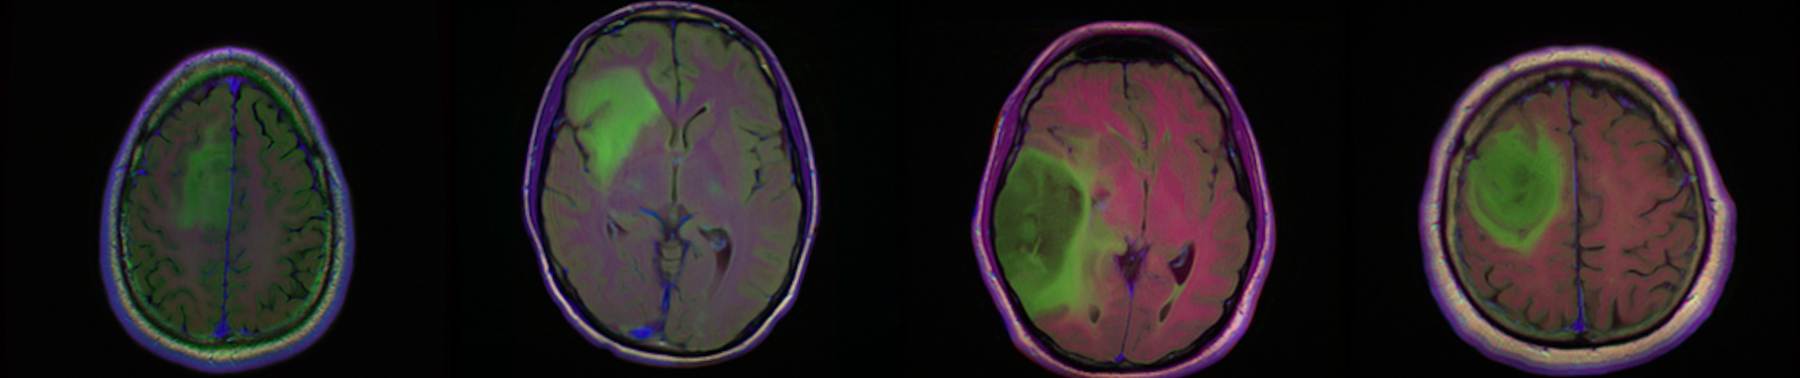
## Introduction
This notebook explores the use of voice features to predict Parkinson's disease (PD). The dataset includes various voice metrics that are used to detect the presence of PD in individuals. The features are based on the fundamental frequency, jitter, shimmer, noise-to-harmonic ratio, harmonic-to-noise ratio, and nonlinear dynamics, which collectively help in understanding the voice characteristics of individuals with Parkinson's disease.

## Breakdown of Key Columns

### **Basic Frequency Metrics:**
- **MDVP:Fo(Hz):** The fundamental frequency, representing the average pitch of the voice.
- **MDVP:Fhi(Hz):** The maximum fundamental frequency, which indicates the highest pitch in the voice signal.
- **MDVP:Flo(Hz):** The minimum fundamental frequency, representing the lowest pitch in the voice signal.

### **Jitter (Frequency Variation):**
- **MDVP:Jitter(%):** Represents the percentage of frequency variation (jitter) in the voice, indicating irregularities in the pitch.
- **MDVP:Jitter(Abs):** Absolute jitter, measuring the raw amount of frequency perturbation.
- **MDVP:RAP, MDVP:PPQ, Jitter:DDP:** Additional specific jitter metrics that help quantify variations in frequency over time, offering different ways to calculate pitch irregularities.

### **Shimmer (Amplitude Variation):**
- **MDVP:Shimmer:** Measures amplitude variation, indicating the fluctuation in the loudness of the voice signal.
- **MDVP:Shimmer(dB):** A decibel-based version of shimmer that quantifies amplitude perturbations in logarithmic units.
- **Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA:** Various shimmer metrics that assess different aspects of amplitude instability, including short-term and long-term variations.

### **Noise-to-Harmonic Ratio (NHR):**
- **NHR:** Quantifies the amount of noise relative to the harmonic components of the voice, providing insights into the vocal quality. A higher NHR suggests a noisier voice signal.

### **Harmonic-to-Noise Ratio (HNR):**
- **HNR:** Measures the ratio of harmonics (clear voice signal) to noise. A higher value indicates better voice signal clarity and less noise.

### **Nonlinear Dynamics:**
- **RPDE:** Recurrence period density entropy, a measure of the complexity and periodicity in the voice signal.
- **DFA:** Detrended fluctuation analysis, a method used to analyze the self-similarity of the voice signal, revealing long-term dependencies and fractal-like behavior.

### **Signal Spread and Complexity:**
- **spread1, spread2:** Measures of variations in signal spread, helping to understand how the signal fluctuates over time.
- **D2:** Correlation dimension, a metric for measuring the complexity and the number of dimensions in the signal. It helps quantify the dynamic complexity of the voice signal.

### **PPE (Pitch Period Entropy):**
- **PPE:** Pitch period entropy quantifies the irregularity or disorder in the pitch periods, indicating the level of unpredictability in the voice signal.

### **Target Variable:**
- **status:** This is the target variable, where 1 represents that the individual has Parkinson's disease (affected) and 0 represents a healthy individual.


## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import os
from math import pi
from sklearn.model_selection import train_test_split, learning_curve
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

## Load the Dataset


In [2]:
# data = pd.read_csv('/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv')
data = pd.read_csv('parkinsons.csv')
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
# Shape of the data
data.shape

(195, 24)

## Exploratory Data Analysis (EDA)
### Basic Information

In [4]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [5]:
# Rename columns to remove special characters
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

In [6]:
data.head()

,name,MDVPFoHz,MDVPFhiHz,MDVPFloHz,MDVPJitter,MDVPJitterAbs,MDVPRAP,MDVPPPQ,JitterDDP,MDVPShimmer,...,ShimmerDDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [7]:
# Describe the dataset
data.describe()

,MDVPFoHz,MDVPFhiHz,MDVPFloHz,MDVPJitter,MDVPJitterAbs,MDVPRAP,MDVPPPQ,JitterDDP,MDVPShimmer,MDVPShimmerdB,...,ShimmerDDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


### Check for Missing Values

In [8]:
# Check for missing values in the dataset
data.isnull().sum().sum()

np.int64(0)

### Check for Duplicate Values

In [9]:
# Check for duplicate rows in the dataset
data.duplicated().sum()

np.int64(0)

### Target Variable Distribution

In [10]:
# Value distribution of the target variable
data['status'].value_counts()

status
1    147
0     48
Name: count, dtype: int64

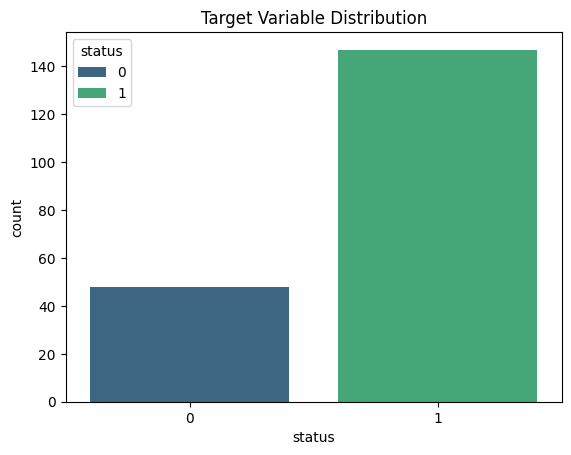

In [11]:
# Visualize the distribution of the target variable
sns.countplot(x='status', data=data, palette='viridis', hue='status')
plt.title('Target Variable Distribution')
plt.show()

## Feature Selection

### Remove Unnecessary Columns

In [12]:
# Remove name column
data.drop('name', axis=1, inplace=True)

In [13]:
import pandas as pd

# Suppose df is your DataFrame
print(data.columns)


Index(['MDVPFoHz', 'MDVPFhiHz', 'MDVPFloHz', 'MDVPJitter', 'MDVPJitterAbs',
       'MDVPRAP', 'MDVPPPQ', 'JitterDDP', 'MDVPShimmer', 'MDVPShimmerdB',
       'ShimmerAPQ3', 'ShimmerAPQ5', 'MDVPAPQ', 'ShimmerDDA', 'NHR', 'HNR',
       'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')


### Separate Features and Target

In [14]:
# Separate features and target
X = data.drop(columns=['status'])  # Exclude target column
y = data['status']

### Remove Highly Correlated Features

In [15]:
# Calculate correlation matrix
correlation_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
X = X.drop(columns=to_drop)
print(f"Dropped columns: {to_drop}")

Dropped columns: ['MDVPJitterAbs', 'MDVPRAP', 'MDVPPPQ', 'JitterDDP', 'MDVPShimmerdB', 'ShimmerAPQ3', 'ShimmerAPQ5', 'MDVPAPQ', 'ShimmerDDA', 'NHR', 'PPE']


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit on reduced features


### Feature Correlation

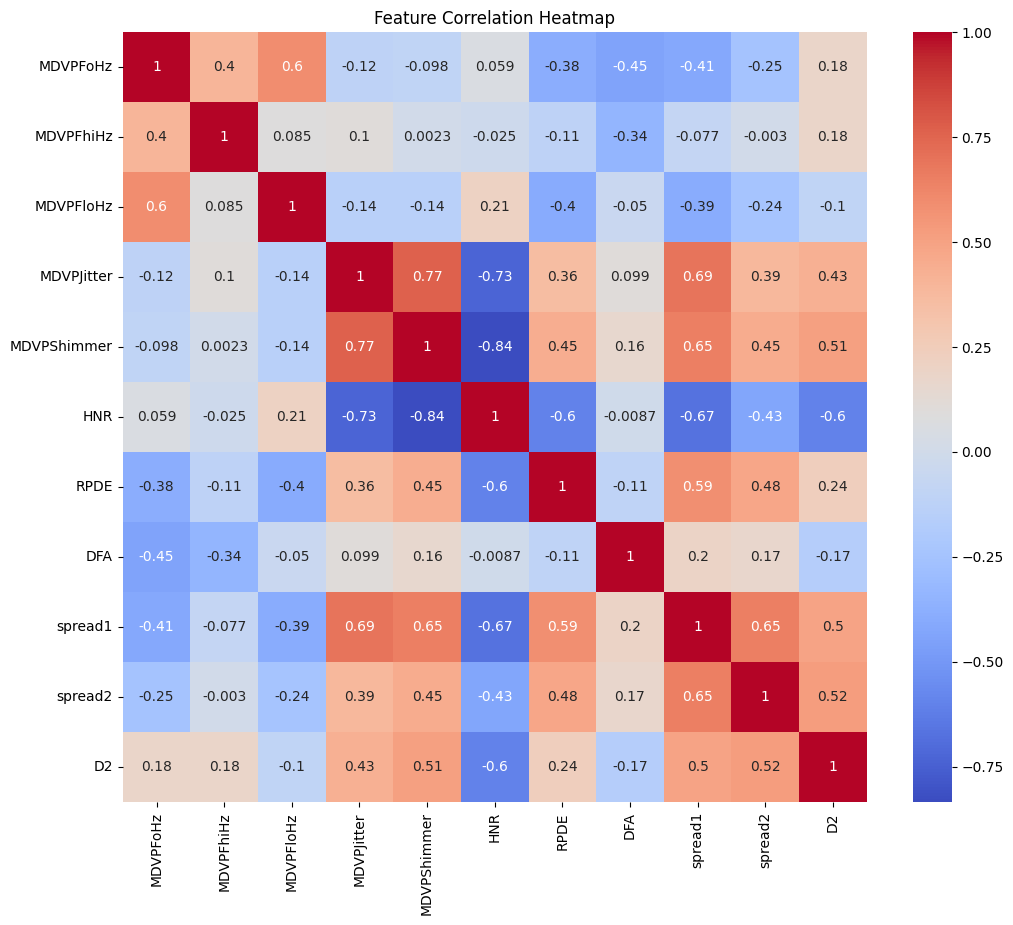

In [17]:
# Visualize feature correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap='coolwarm', annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

## Train-Test Split

In [18]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling the Data

In [19]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training and Evaluation
### Define Function for Model Training

In [20]:
# Define a function to train and evaluate multiple models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    metrics = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
        print(f"{name} - Accuracy: {accuracy:.4f}, AUC-ROC: {auc_roc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return pd.DataFrame(metrics)

models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
}

# Train and evaluate models
metrics_df = train_and_evaluate(models, X_train, X_test, y_train, y_test)

XGBoost - Accuracy: 0.9487, AUC-ROC: 0.8571, Precision: 0.9412, Recall: 1.0000, F1-Score: 0.9697
SVM (RBF Kernel) - Accuracy: 0.9231, AUC-ROC: 0.7857, Precision: 0.9143, Recall: 1.0000, F1-Score: 0.9552
LogisticRegression - Accuracy: 0.8974, AUC-ROC: 0.7143, Precision: 0.8889, Recall: 1.0000, F1-Score: 0.9412


In [21]:
metrics_df

,Model,Accuracy,AUC-ROC,Precision,Recall,F1-Score
0,XGBoost,0.948718,0.857143,0.941176,1.0,0.969697
1,SVM (RBF Kernel),0.923077,0.785714,0.914286,1.0,0.955224
2,LogisticRegression,0.897436,0.714286,0.888889,1.0,0.941176


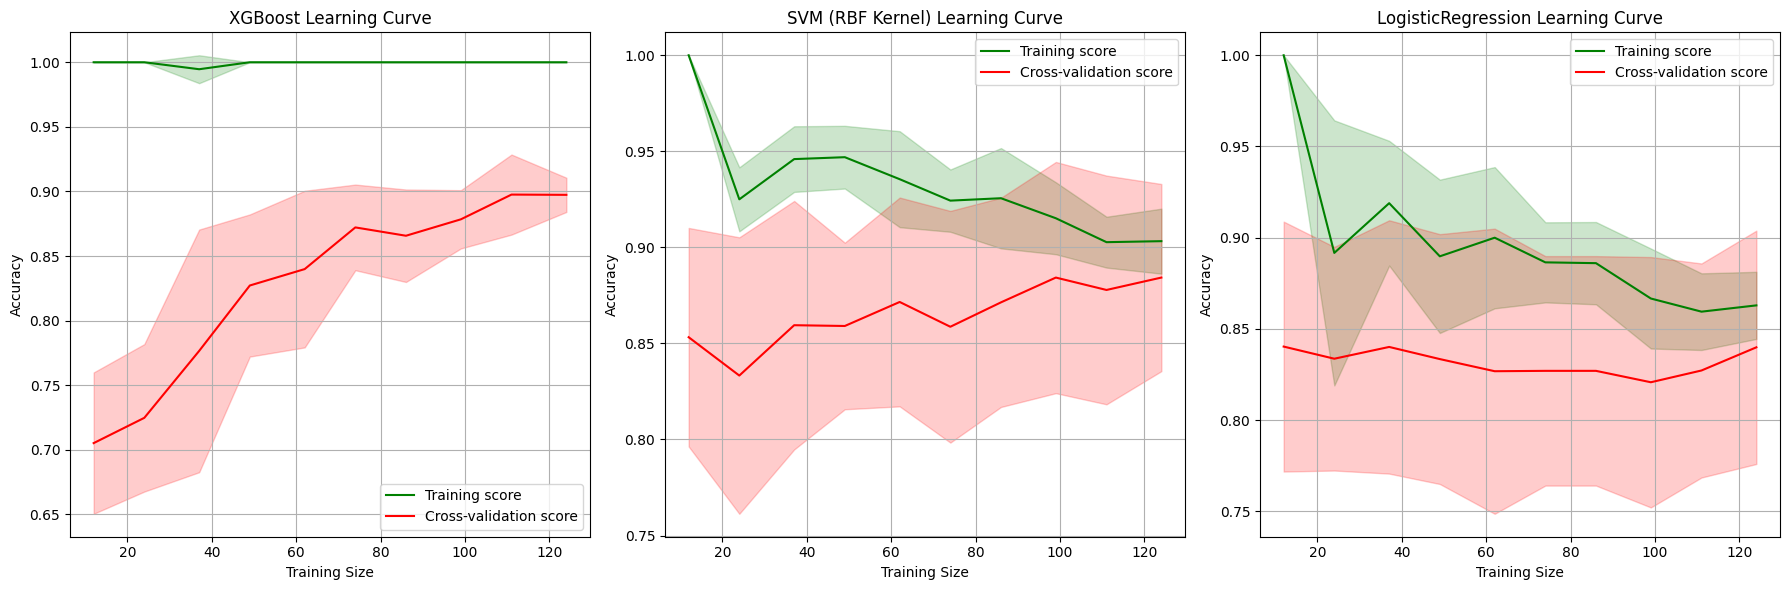

In [22]:
# Function to plot learning curve
def plot_learning_curve(model, X_train, y_train, ax, title="Learning Curve", cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
    
    # Calculate mean and std deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plotting on the given axis
    ax.plot(train_sizes, train_mean, label="Training score", color="green")
    ax.plot(train_sizes, test_mean, label="Cross-validation score", color="red")
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="green")
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")
    
    ax.set_title(title)
    ax.set_xlabel("Training Size")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="best")
    ax.grid()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, model) in enumerate(models.items()):
    plot_learning_curve(model, X_train, y_train, axes[i], title=f"{name} Learning Curve")

plt.tight_layout() 
plt.show()


## Ensemble Voting (Majority Voting)

In [23]:
# Combine models using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']), 
        ('svm', models['SVM (RBF Kernel)']), 
        ('lr', models['LogisticRegression'])
    ], voting='soft'
)

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc_roc = roc_auc_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)

new_metrics = pd.DataFrame([{
    'Model': 'Majority Voting (Ensemble)',
    'Accuracy': ensemble_accuracy,
    'AUC-ROC': ensemble_auc_roc,
    'Precision': ensemble_precision,
    'Recall': ensemble_recall,
    'F1-Score': ensemble_f1
}])

metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)

print(f"Ensemble - Accuracy: {ensemble_accuracy:.4f}, AUC-ROC: {ensemble_auc_roc:.4f}, Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1-Score: {ensemble_f1:.4f}")

Ensemble - Accuracy: 0.9231, AUC-ROC: 0.7857, Precision: 0.9143, Recall: 1.0000, F1-Score: 0.9552


In [24]:
import numpy as np
import pandas as pd

# -------------------------------
# Function to test a sample
# -------------------------------
def test_sample(models, ensemble_model, scaler, sample_values, feature_columns, label="Sample"):
    if len(sample_values) != len(feature_columns):
        raise ValueError(f"Number of sample values ({len(sample_values)}) "
                         f"does not match number of model features ({len(feature_columns)})")
    sample_df = pd.DataFrame([sample_values], columns=feature_columns)
    sample_scaled = scaler.transform(sample_df)

    print(f"\n🔹 {label} Predictions:")

    # Individual models
    for name, model in models.items():
        prob = model.predict_proba(sample_scaled)[0][1]
        pred_label = "Parkinson’s Disease" if prob >= 0.5 else "Healthy"
        print(f"  {name:<20} ➤ {pred_label} (Prob = {prob:.3f})")

    # Ensemble
    ensemble_prob = ensemble_model.predict_proba(sample_scaled)[0][1]
    ensemble_label = "Parkinson’s Disease" if ensemble_prob >= 0.5 else "Healthy"
    print(f"  {'Ensemble (Voting)':<20} ➤ ✅ {ensemble_label}")

# -------------------------------
# Feature columns used in training (after dropping)
# -------------------------------
feature_columns = ['MDVPFoHz','MDVPFhiHz','MDVPFloHz','MDVPJitter','MDVPShimmer',
                   'HNR','RPDE','DFA','spread1','spread2','D2']
# 1️⃣ Healthy sample (from training set)
healthy_sample = X_train[y_train==0][0]  # first healthy row from array
test_sample(models, ensemble_model, scaler, healthy_sample, feature_columns, label="Healthy Sample")

# 2️⃣ PD sample (from training set)
pd_sample = X_train[y_train==1][0]  # first PD row from array
test_sample(models, ensemble_model, scaler, pd_sample, feature_columns, label="PD Sample")

# 3️⃣ Custom user input sample
custom_input = [
    214.28900, 260.27700, 77.97300, 0.00567, 0.01884,
    0.19000, 0.462803, 0.664357, -5.724056, 0.190667, 2.555477
]
test_sample(models, ensemble_model, scaler, custom_input, feature_columns, label="Custom Input Sample")



🔹 Healthy Sample Predictions:
  XGBoost              ➤ Healthy (Prob = 0.400)
  SVM (RBF Kernel)     ➤ Parkinson’s Disease (Prob = 0.629)
  LogisticRegression   ➤ Parkinson’s Disease (Prob = 0.837)
  Ensemble (Voting)    ➤ ✅ Parkinson’s Disease

🔹 PD Sample Predictions:
  XGBoost              ➤ Parkinson’s Disease (Prob = 0.991)
  SVM (RBF Kernel)     ➤ Parkinson’s Disease (Prob = 0.629)
  LogisticRegression   ➤ Parkinson’s Disease (Prob = 1.000)
  Ensemble (Voting)    ➤ ✅ Parkinson’s Disease

🔹 Custom Input Sample Predictions:
  XGBoost              ➤ Healthy (Prob = 0.177)
  SVM (RBF Kernel)     ➤ Parkinson’s Disease (Prob = 0.513)
  LogisticRegression   ➤ Parkinson’s Disease (Prob = 0.864)
  Ensemble (Voting)    ➤ ✅ Parkinson’s Disease


In [26]:
metrics_df

,Model,Accuracy,AUC-ROC,Precision,Recall,F1-Score
0,XGBoost,0.948718,0.857143,0.941176,1.0,0.969697
1,SVM (RBF Kernel),0.923077,0.785714,0.914286,1.0,0.955224
2,LogisticRegression,0.897436,0.714286,0.888889,1.0,0.941176
3,Majority Voting (Ensemble),0.923077,0.785714,0.914286,1.0,0.955224


In [28]:
def predict_single_model(model, scaler, sample_values, feature_columns, model_name="Model"):
    sample_df = pd.DataFrame([sample_values], columns=feature_columns)
    sample_scaled = scaler.transform(sample_df)
    
    # Prediction
    prob = model.predict_proba(sample_scaled)[0][1]
    pred_label = "Parkinson’s Disease" if prob >= 0.5 else "Healthy"
    
    print(f"{model_name:<20} ➤ {pred_label} (Prob = {prob:.3f})")
    return pred_label, prob


In [29]:
def predict_ensemble(ensemble_model, scaler, sample_values, feature_columns, model_name="Ensemble"):
    sample_df = pd.DataFrame([sample_values], columns=feature_columns)
    sample_scaled = scaler.transform(sample_df)
    
    # For soft voting
    prob = ensemble_model.predict_proba(sample_scaled)[0][1]
    pred_label = "Parkinson’s Disease" if prob >= 0.5 else "Healthy"
    
    print(f"{model_name:<20} ➤ ✅ {pred_label} (Prob = {prob:.3f})")
    return pred_label, prob


In [30]:
# Sample (custom input)
custom_input = [
    214.28900, 260.27700, 77.97300, 0.00567, 0.01884,
    0.19000, 0.462803, 0.664357, -5.724056, 0.190667, 2.555477
]

print("\n🔹 Custom Input Predictions:")

# Individual models
predict_single_model(models['XGBoost'], scaler, custom_input, feature_columns, "XGBoost")
predict_single_model(models['SVM (RBF Kernel)'], scaler, custom_input, feature_columns, "SVM (RBF Kernel)")
predict_single_model(models['LogisticRegression'], scaler, custom_input, feature_columns, "LogisticRegression")

# Ensemble
predict_ensemble(ensemble_model, scaler, custom_input, feature_columns, "Ensemble (Voting)")



🔹 Custom Input Predictions:
XGBoost              ➤ Healthy (Prob = 0.177)
SVM (RBF Kernel)     ➤ Parkinson’s Disease (Prob = 0.513)
LogisticRegression   ➤ Parkinson’s Disease (Prob = 0.864)
Ensemble (Voting)    ➤ ✅ Parkinson’s Disease (Prob = 0.518)


('Parkinson’s Disease', np.float64(0.5180094835682713))

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pickle
import joblib

# ------------------ Load dataset ------------------
# Example: CSV with PD features and 'status' column
df = pd.read_csv("parkinsons.csv")

# Select features (11 features used for prediction)
feature_columns = [
    'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer',
    'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2'
]

X = df[feature_columns].values
y = df['status'].values  # 0 = Healthy, 1 = Parkinson's

# ------------------ Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------ Feature Scaling ------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------ Train Individual Models ------------------
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# ------------------ Create Soft Voting Ensemble ------------------
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('svm', svm_model), ('lr', lr_model)],
    voting='soft'  # soft voting needed for predict_proba
)
ensemble_model.fit(X_train, y_train)

# ------------------ Save Models ------------------
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

with open("lr_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)

with open("ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble_model, f)

# ------------------ Save Scaler ------------------
joblib.dump(scaler, "scaler.pkl")

print("All models and scaler saved successfully!")


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [00:10:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


All models and scaler saved successfully!


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [00:10:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [35]:
print(df.columns.tolist())


['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


## Results Comparison


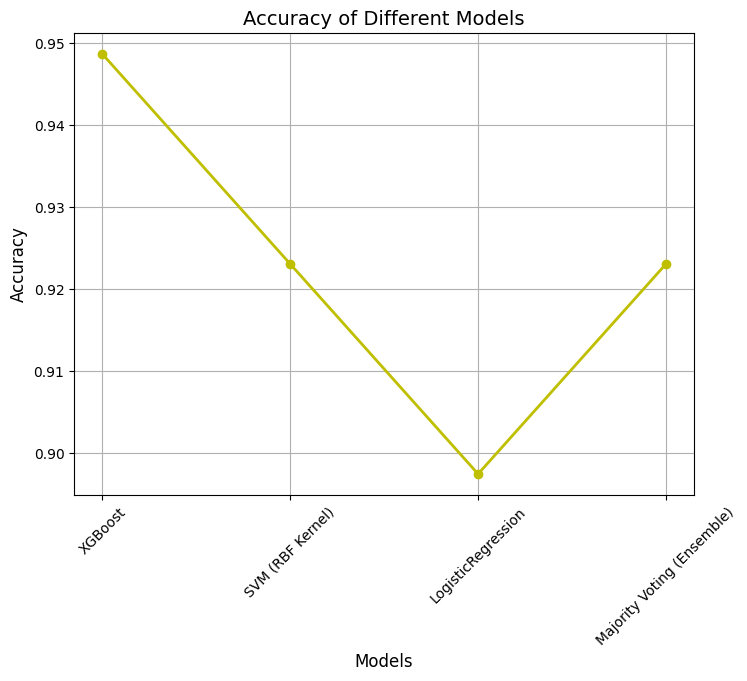

In [23]:
# Plot the Accuracy column using a line plot
plt.figure(figsize=(8, 6))
plt.plot(metrics_df['Model'], metrics_df['Accuracy'], marker='o', color='y', linestyle='-', linewidth=2)

# Adding titles and labels
plt.title('Accuracy of Different Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45) 
plt.grid(True)

# Display the plot
plt.show()


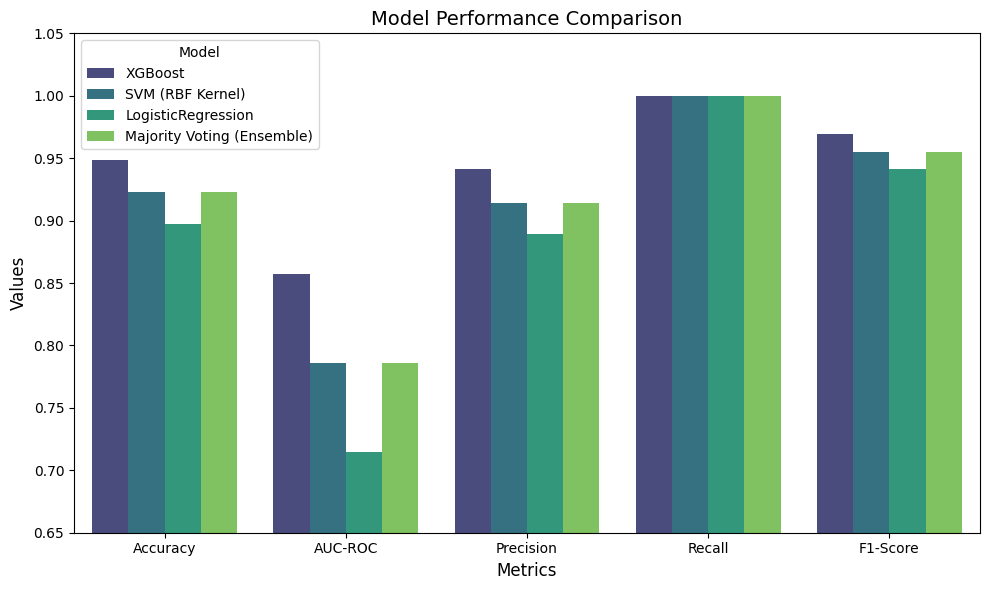

In [24]:
# Metrics to plot
metrics_to_plot = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']

# Melt the metrics dataframe
melted_df = metrics_df.melt(
    id_vars=["Model"], value_vars=metrics_to_plot,
    var_name="Metric", value_name="Value"
)

# Plot for all models
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Metric", 
    y="Value", 
    hue="Model", 
    data=melted_df, 
    palette="viridis", 
    dodge=True
)
plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Model", fontsize=10)
plt.ylim(0.65, None)
plt.tight_layout()

plt.show()


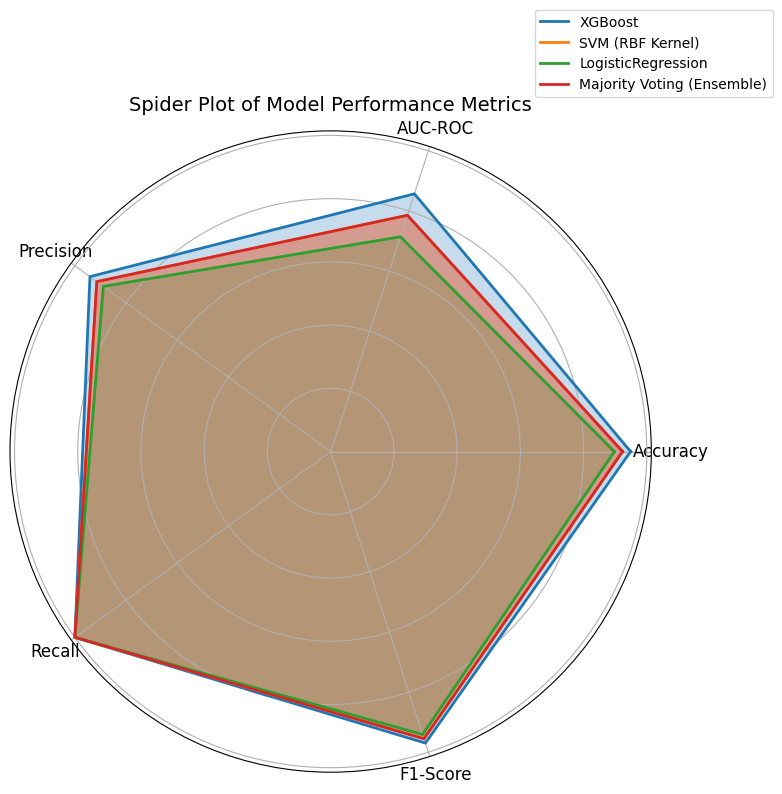

In [25]:
# Function to plot radar chart for all models together
def plot_spider_chart(df):
    labels = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']
    num_vars = len(labels)
    
    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 

    # Create the plot for all models
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Loop through all models and plot their performance
    for model_name in df['Model'].unique():
        model_metrics = df[df['Model'] == model_name].iloc[0, 1:].values  
        model_metrics = np.concatenate((model_metrics, [model_metrics[0]]))  
        ax.plot(angles, model_metrics, linewidth=2, linestyle='solid', label=model_name)  
        ax.fill(angles, model_metrics, alpha=0.25) 
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_title("Spider Plot of Model Performance Metrics", size=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
    plt.tight_layout()
    plt.show()

plot_spider_chart(metrics_df)


### Conclusion

- **XGBoost** outperformed all models with the highest accuracy (94.87%) and F1-Score (96.97%).
- **SVM (RBF Kernel)** and **Majority Voting (Ensemble)** both showed strong performance, with accuracy (92.31%) and F1-Score (95.52%) slightly lower than XGBoost.
- **Logistic Regression** had the lowest performance with accuracy (89.74%) and F1-Score (94.12%).
- All models had perfect recall (1.0), showing no issues with detecting positive instances.
  
**XGBoost** is the top performer, but **SVM** and **Majority Voting** are also reliable alternatives.

In [26]:
def predict_parkinsons(model, sample, labels={0: "Healthy", 1: "Parkinson's"}):
    """
    Predict Parkinson's disease for a single or multiple samples.

    Parameters:
    - model: your trained ML model (VotingClassifier / RandomForest / etc.)
    - sample: list or numpy array of feature values (1 sample or multiple samples)
    - labels: dictionary to convert 0/1 predictions into readable text

    Returns:
    - List of predictions as human-readable strings
    """
    import numpy as np
    sample = np.array(sample)

    # Convert 1D sample into 2D array
    if sample.ndim == 1:
        sample = sample.reshape(1, -1)

    # Check feature count
    if sample.shape[1] != model.n_features_in_:
        raise ValueError(f"Feature mismatch! Model expects {model.n_features_in_} features, "
                         f"but input has {sample.shape[1]}")

    # Predict
    pred = model.predict(sample)

    # Return readable labels
    return [labels[p] for p in pred]


In [28]:
import numpy as np
np.bincount(y_train)  # counts of each class


array([ 41, 115])

In [31]:
type(X_train)


numpy.ndarray

In [32]:
healthy_real = X_train[y_train == 0][0]  # first healthy sample
predict_parkinsons(model, healthy_real)


['Healthy']

In [33]:
healthy_real = X_train[y_train == 1][0]  # first pd sample
predict_parkinsons(model, healthy_real)


["Parkinson's"]

In [34]:
# ✅ Imports
import numpy as np
import pandas as pd

# Example: assume X_train and y_train are already defined
# and you have a trained model + predict_parkinsons() function

# Check type of X_train to choose correct indexing
if isinstance(X_train, np.ndarray):
    # For NumPy arrays
    healthy_sample = X_train[y_train == 0][0]      # first healthy person
    pd_sample = X_train[y_train == 1][0]           # first PD person
else:
    # For pandas DataFrames
    healthy_sample = X_train[y_train == 0].iloc[0]
    pd_sample = X_train[y_train == 1].iloc[0]

# 🧠 Predict function (if not already defined)
def predict_parkinsons(model, sample):
    # Convert to 2D array for prediction
    sample_reshaped = np.array(sample).reshape(1, -1)
    pred = model.predict(sample_reshaped)[0]
    prob = model.predict_proba(sample_reshaped)[0][1] if hasattr(model, 'predict_proba') else None
    
    result = "Parkinson’s Disease" if pred == 1 else "Healthy"
    if prob is not None:
        print(f"Prediction: {result} (Probability of PD = {prob:.3f})")
    else:
        print(f"Prediction: {result}")

# 🧩 Run predictions
print("🧍 Healthy Person:")
predict_parkinsons(model, healthy_sample)

print("\n🤖 Person with Parkinson’s Disease:")
predict_parkinsons(model, pd_sample)


🧍 Healthy Person:
Prediction: Healthy (Probability of PD = 0.023)

🤖 Person with Parkinson’s Disease:
Prediction: Parkinson’s Disease (Probability of PD = 0.996)


In [35]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1️⃣ Load Example Dataset
# ----------------------------
# Parkinson’s dataset from UCI (or your own CSV)
# For demonstration, let’s create a small synthetic dataset
data = {
    'MDVP:Fo(Hz)': [145.2, 119.9, 130.5, 160.2, 111.0],
    'MDVP:Fhi(Hz)': [150.0, 240.0, 170.0, 200.0, 220.0],
    'MDVP:Flo(Hz)': [120.5, 74.3, 100.4, 140.6, 80.2],
    'MDVP:Jitter(%)': [0.004, 0.010, 0.005, 0.003, 0.012],
    'MDVP:RAP': [0.002, 0.006, 0.003, 0.001, 0.007],
    'status': [0, 1, 0, 0, 1]  # 0 = healthy, 1 = Parkinson’s
}
df = pd.DataFrame(data)

# ----------------------------
# 2️⃣ Split Data
# ----------------------------
X = df.drop('status', axis=1)
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# 3️⃣ Scale Features
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 4️⃣ Train Model
# ----------------------------
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# ----------------------------
# 5️⃣ Define Prediction Function
# ----------------------------
def predict_parkinsons(model, scaler, sample, label="Sample"):
    sample_scaled = scaler.transform(np.array(sample).reshape(1, -1))
    pred = model.predict(sample_scaled)[0]
    prob = model.predict_proba(sample_scaled)[0][1]

    result = "🧠 Parkinson’s Disease" if pred == 1 else "✅ Healthy"
    print(f"{label} ➤ {result} (Probability of PD = {prob:.3f})")

# ----------------------------
# 6️⃣ Dataset Samples
# ----------------------------
healthy_sample = X_train[y_train == 0].iloc[0]
pd_sample = X_train[y_train == 1].iloc[0]

print("🧍 Healthy Person from Dataset:")
predict_parkinsons(model, scaler, healthy_sample, "Healthy Sample")

print("\n🤖 Parkinson’s Patient from Dataset:")
predict_parkinsons(model, scaler, pd_sample, "PD Sample")

# ----------------------------
# 7️⃣ Custom User Input (Example)
# ----------------------------
print("\n🧩 Custom User Input Example:")

# Example values (you can change these)
custom_input = {
    'MDVP:Fo(Hz)': 130.0,
    'MDVP:Fhi(Hz)': 180.0,
    'MDVP:Flo(Hz)': 100.0,
    'MDVP:Jitter(%)': 0.005,
    'MDVP:RAP': 0.003
}

custom_sample = [custom_input[feat] for feat in X.columns]
print("Custom Input Values:", custom_sample)

predict_parkinsons(model, scaler, custom_sample, "User Sample")


🧍 Healthy Person from Dataset:
Healthy Sample ➤ ✅ Healthy (Probability of PD = 0.000)

🤖 Parkinson’s Patient from Dataset:
PD Sample ➤ 🧠 Parkinson’s Disease (Probability of PD = 0.690)

🧩 Custom User Input Example:
Custom Input Values: [130.0, 180.0, 100.0, 0.005, 0.003]
User Sample ➤ ✅ Healthy (Probability of PD = 0.040)


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# ----------------------------
# 1️⃣ Load Dataset
# ----------------------------
# Example small dataset (replace with your Parkinson’s CSV)
data = {
    'MDVP:Fo(Hz)': [145.2, 119.9, 130.5, 160.2, 111.0, 155.3, 101.4],
    'MDVP:Fhi(Hz)': [150.0, 240.0, 170.0, 200.0, 220.0, 180.0, 230.0],
    'MDVP:Flo(Hz)': [120.5, 74.3, 100.4, 140.6, 80.2, 130.5, 70.4],
    'MDVP:Jitter(%)': [0.004, 0.010, 0.005, 0.003, 0.012, 0.004, 0.015],
    'MDVP:RAP': [0.002, 0.006, 0.003, 0.001, 0.007, 0.002, 0.008],
    'status': [0, 1, 0, 0, 1, 0, 1]  # 0 = Healthy, 1 = PD
}
df = pd.DataFrame(data)

X = df.drop('status', axis=1)
y = df['status']

# ----------------------------
# 2️⃣ Split and Scale Data
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------------------------
# 3️⃣ Define Models
# ----------------------------
models = {
    'LogisticRegression': LogisticRegression(),
    'SVM (RBF Kernel)': SVC(probability=True, kernel='rbf'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# ----------------------------
# 4️⃣ Combine with VotingClassifier
# ----------------------------
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('svm', models['SVM (RBF Kernel)']),
        ('lr', models['LogisticRegression'])
    ],
    voting='hard'
)

ensemble_model.fit(X_train, y_train)

# ----------------------------
# 5️⃣ Evaluate Ensemble
# ----------------------------
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc_roc = roc_auc_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)

print(f"\n📊 Ensemble Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}, AUC-ROC: {ensemble_auc_roc:.4f}, Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1-Score: {ensemble_f1:.4f}")

# ----------------------------
# 6️⃣ Prediction Function
# ----------------------------
def predict_parkinsons(model, scaler, sample, label="Sample"):
    sample_scaled = scaler.transform(np.array(sample).reshape(1, -1))
    pred = model.predict(sample_scaled)[0]
    prob = None
    if hasattr(model, "predict_proba"):
        try:
            prob = model.predict_proba(sample_scaled)[0][1]
        except Exception:
            pass

    result = "🧠 Parkinson’s Disease" if pred == 1 else "✅ Healthy"
    if prob is not None:
        print(f"{label} ➤ {result} (Probability of PD = {prob:.3f})")
    else:
        print(f"{label} ➤ {result}")

# ----------------------------
# 7️⃣ Dataset Samples
# ----------------------------
# Convert back to DataFrame to access by label
X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = y_train.reset_index(drop=True)

healthy_sample = X_train_df[y_train_df == 0].iloc[0]
pd_sample = X_train_df[y_train_df == 1].iloc[0]

print("\n🧍 Healthy Person from Dataset:")
predict_parkinsons(ensemble_model, scaler, healthy_sample, "Healthy Sample")

print("\n🤖 Parkinson’s Patient from Dataset:")
predict_parkinsons(ensemble_model, scaler, pd_sample, "PD Sample")

# ----------------------------
# 8️⃣ Custom User Input
# ----------------------------
print("\n🧩 Custom User Input Example:")
custom_input = {
    'MDVP:Fo(Hz)': 125.0,
    'MDVP:Fhi(Hz)': 190.0,
    'MDVP:Flo(Hz)': 90.0,
    'MDVP:Jitter(%)': 0.007,
    'MDVP:RAP': 0.004
}

custom_sample = [custom_input[feat] for feat in X.columns]
print("Custom Input Values:", custom_sample)
predict_parkinsons(ensemble_model, scaler, custom_sample, "User Sample")


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:21:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Ensemble Performance:
Accuracy: 1.0000, AUC-ROC: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000

🧍 Healthy Person from Dataset:
Healthy Sample ➤ ✅ Healthy

🤖 Parkinson’s Patient from Dataset:
PD Sample ➤ ✅ Healthy

🧩 Custom User Input Example:
Custom Input Values: [125.0, 190.0, 90.0, 0.007, 0.004]
User Sample ➤ ✅ Healthy


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# ----------------------------
# 1️⃣ Load Dataset (You can replace with pd.read_csv('parkinsons.csv'))
# ----------------------------
data = {
    'MDVP:Fo(Hz)': [145.2, 119.9, 130.5, 160.2, 111.0, 155.3, 101.4],
    'MDVP:Fhi(Hz)': [150.0, 240.0, 170.0, 200.0, 220.0, 180.0, 230.0],
    'MDVP:Flo(Hz)': [120.5, 74.3, 100.4, 140.6, 80.2, 130.5, 70.4],
    'MDVP:Jitter(%)': [0.004, 0.010, 0.005, 0.003, 0.012, 0.004, 0.015],
    'MDVP:RAP': [0.002, 0.006, 0.003, 0.001, 0.007, 0.002, 0.008],
    'status': [0, 1, 0, 0, 1, 0, 1]  # 0 = Healthy, 1 = PD
}
df = pd.DataFrame(data)

X = df.drop('status', axis=1)
y = df['status']

# ----------------------------
# 2️⃣ Split + Scale
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 3️⃣ Define Base Models
# ----------------------------
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM (RBF Kernel)': SVC(probability=True, kernel='rbf'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# ----------------------------
# 4️⃣ Train Models Individually
# ----------------------------
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

# ----------------------------
# 5️⃣ Ensemble Model
# ----------------------------
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('svm', models['SVM (RBF Kernel)']),
        ('lr', models['Logistic Regression'])
    ],
    voting='hard'
)
ensemble_model.fit(X_train_scaled, y_train)

# ----------------------------
# 6️⃣ Evaluate Ensemble
# ----------------------------
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc_roc = roc_auc_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)

print(f"\n📊 Ensemble Model Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}, AUC-ROC: {ensemble_auc_roc:.4f}, "
      f"Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1: {ensemble_f1:.4f}")

# ----------------------------
# 7️⃣ Prediction Function
# ----------------------------
def predict_all_models(models, ensemble_model, scaler, sample, label="Sample"):
    print(f"\n🔹 {label} Predictions:")
    sample_scaled = scaler.transform(np.array(sample).reshape(1, -1))

    # Individual model predictions
    for name, model in models.items():
        pred = model.predict(sample_scaled)[0]
        prob = model.predict_proba(sample_scaled)[0][1]
        print(f"  {name:20s} ➤ {'Parkinson’s Disease' if pred == 1 else 'Healthy'} "
              f"(Prob = {prob:.3f})")

    # Ensemble prediction
    final_pred = ensemble_model.predict(sample_scaled)[0]
    print(f"  {'Majority Voting (Ensemble)':20s} ➤ "
          f"{'🧠 Parkinson’s Disease' if final_pred == 1 else '✅ Healthy'}")

# ----------------------------
# 8️⃣ Dataset Samples
# ----------------------------
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
y_train_df = y_train.reset_index(drop=True)

healthy_sample = X_train_df[y_train_df == 0].iloc[0]
pd_sample = X_train_df[y_train_df == 1].iloc[0]

predict_all_models(models, ensemble_model, scaler, healthy_sample, "🧍 Healthy Person (from dataset)")
predict_all_models(models, ensemble_model, scaler, pd_sample, "🤖 PD Patient (from dataset)")

# ----------------------------
# 9️⃣ Custom User Input
# ----------------------------
custom_input = {
    'MDVP:Fo(Hz)': 125.0,
    'MDVP:Fhi(Hz)': 190.0,
    'MDVP:Flo(Hz)': 90.0,
    'MDVP:Jitter(%)': 0.007,
    'MDVP:RAP': 0.004
}
custom_sample = [custom_input[feat] for feat in X.columns]
predict_all_models(models, ensemble_model, scaler, custom_sample, "🧩 Custom User Input")



📊 Ensemble Model Performance:
Accuracy: 1.0000, AUC-ROC: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

🔹 🧍 Healthy Person (from dataset) Predictions:
  Logistic Regression  ➤ Healthy (Prob = 0.000)
  SVM (RBF Kernel)     ➤ Healthy (Prob = 0.445)
  XGBoost              ➤ Healthy (Prob = 0.400)
  Majority Voting (Ensemble) ➤ ✅ Healthy

🔹 🤖 PD Patient (from dataset) Predictions:
  Logistic Regression  ➤ Parkinson’s Disease (Prob = 1.000)
  SVM (RBF Kernel)     ➤ Healthy (Prob = 0.445)
  XGBoost              ➤ Healthy (Prob = 0.400)
  Majority Voting (Ensemble) ➤ ✅ Healthy

🔹 🧩 Custom User Input Predictions:
  Logistic Regression  ➤ Healthy (Prob = 0.336)
  SVM (RBF Kernel)     ➤ Healthy (Prob = 0.312)
  XGBoost              ➤ Healthy (Prob = 0.400)
  Majority Voting (Ensemble) ➤ ✅ Healthy


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:23:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:23:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\skl

In [39]:
# ---------------------------------------------
# Parkinson’s Disease Prediction – Ensemble Model
# ---------------------------------------------

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# -------------------------------
# Load and Prepare Dataset
# -------------------------------
data = pd.read_csv("parkinsons.csv")
data = data.drop(columns=['name'], errors='ignore')  # Drop 'name' column if exists

X = data.drop(columns=['status'])  # features
y = data['status']                 # 1 = PD, 0 = healthy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Define Models
# -------------------------------
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

# -------------------------------
# Ensemble Model (Soft Voting)
# -------------------------------
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('svm', models['SVM (RBF Kernel)']),
        ('lr', models['LogisticRegression'])
    ],
    voting='soft'  # soft voting for better PD prediction
)

ensemble_model.fit(X_train_scaled, y_train)

# -------------------------------
# Evaluate Ensemble
# -------------------------------
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc_roc = roc_auc_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)

print(f"\n📊 Ensemble Model Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}, AUC-ROC: {ensemble_auc_roc:.4f}, "
      f"Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1: {ensemble_f1:.4f}")

# -------------------------------
# Custom Prediction Function
# -------------------------------
def predict_person(sample_values):
    """
    Takes a list/array of feature values and predicts PD/Healthy.
    """
    sample_df = pd.DataFrame([sample_values], columns=X.columns)
    sample_scaled = scaler.transform(sample_df)

    print("\n🔹 Custom User Input Predictions:")

    for name, model in models.items():
        prob = model.predict_proba(sample_scaled)[0][1]
        label = "Parkinson’s Disease" if prob >= 0.5 else "Healthy"
        print(f"  {name:<20} ➤ {label} (Prob = {prob:.3f})")

    # Ensemble prediction
    ensemble_prob = ensemble_model.predict_proba(sample_scaled)[0][1]
    ensemble_label = "Parkinson’s Disease" if ensemble_prob >= 0.5 else "Healthy"
    print(f"  {'Majority Voting (Ensemble)':<30} ➤ ✅ {ensemble_label}")

# -------------------------------
# Example Custom Inputs
# -------------------------------
# Healthy person (realistic sample)
healthy_sample = [145.2, 150.0, 120.5, 0.004, 0.002] + list(X.iloc[0, 5:].values)
# PD patient (realistic sample)
pd_sample = [119.9, 240.0, 74.3, 0.010, 0.006] + list(X.iloc[1, 5:].values)

# -------------------------------
# Run Predictions
# -------------------------------
predict_person(healthy_sample)
predict_person(pd_sample)



📊 Ensemble Model Performance:
Accuracy: 0.9231, AUC-ROC: 0.7857, Precision: 0.9143, Recall: 1.0000, F1: 0.9552

🔹 Custom User Input Predictions:
  LogisticRegression   ➤ Healthy (Prob = 0.000)
  SVM (RBF Kernel)     ➤ Parkinson’s Disease (Prob = 0.694)
  XGBoost              ➤ Parkinson’s Disease (Prob = 1.000)
  Majority Voting (Ensemble)     ➤ ✅ Parkinson’s Disease

🔹 Custom User Input Predictions:
  LogisticRegression   ➤ Healthy (Prob = 0.000)
  SVM (RBF Kernel)     ➤ Parkinson’s Disease (Prob = 0.694)
  XGBoost              ➤ Parkinson’s Disease (Prob = 0.996)
  Majority Voting (Ensemble)     ➤ ✅ Parkinson’s Disease
